# Predictive Marketing Classification using Logistic Regression
The goal of this project is to predict new buyers of one of the new m1 macs that apple first released last november. To collect the data, a survey has been conducted to gather relevant customer data. The dataset consists of a number of features relevant to a m1 purchase, such as current apple product and interest in computers, in addition to personal information like age and occupation. The aim of the analysis is to understand which features have the stongest relation to the (y), and to to use them (x) to fit a model that can predict if new customers will buy one of the new m1 macbooks or not. The algorithm used will be Logistic Regression from sklearn. 

In [40]:
#importing the packages
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from math import sqrt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from termcolor import colored as cl

In [41]:
#loading the dataset 
apple = pd.read_csv("applem1_data_final.csv")

In [42]:
#displaying the df named apple
apple

,trust_apple,interest_computers,age_computer,user_pcmac,appleproducts_count,familiarity_m1,f_batterylife,f_price,f_size,f_multitasking,f_noise,f_performance,f_neural,f_synergy,f_performanceloss,m1_consideration,m1_purchase,gender,age_group,income_group,status,domain
0,No,4,8,PC,0,No,5,4,3,4,4,2,2,1,1,1,Yes,Male,2,2,Student,Science
1,Yes,2,4,PC,1,No,5,5,5,3,4,5,2,2,4,2,No,Male,2,3,Employed,Finance
2,Yes,5,6,PC,0,No,3,4,2,4,1,4,2,2,2,4,Yes,Male,2,2,Student,IT & Technology
3,Yes,2,6,Apple,4,No,4,3,3,4,4,4,4,4,3,2,No,Female,2,2,Student,Arts & Culture
4,Yes,4,4,Apple,7,Yes,5,3,3,4,4,5,3,4,4,4,Yes,Male,5,7,Employed,Hospitality
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,Yes,5,0,PC,1,Yes,5,3,3,5,4,5,5,3,3,5,Yes,Male,3,3,Student,Engineering
129,Yes,5,8,Apple,5,Yes,4,3,2,4,4,4,2,3,1,5,Yes,Male,3,5,Employed,Administration & Public Services
130,Yes,4,0,Apple,8,Yes,5,4,3,5,5,5,4,4,5,5,Yes,Female,2,3,Student,Marketing
131,Yes,5,5,Apple,4,Yes,5,3,4,4,4,5,2,3,3,5,Yes,Female,2,2,Student,IT & Technology


In [43]:
#displaying the columns
apple.columns

Index(['trust_apple', 'interest_computers', 'age_computer', 'user_pcmac',
       'appleproducts_count', 'familiarity_m1', 'f_batterylife', 'f_price',
       'f_size', 'f_multitasking', 'f_noise', 'f_performance', 'f_neural',
       'f_synergy', 'f_performanceloss', 'm1_consideration', 'm1_purchase',
       'gender', 'age_group', 'income_group', 'status', 'domain'],
      dtype='object')

In [44]:
#viewing the values for the status column
apple['status'].unique()

array(['Student', 'Employed', 'Retired', 'Student ant employed',
       'Unemployed', 'Self-Employed'], dtype=object)

In [45]:
#viewing the values for the domain column 
apple['domain'].unique()

array(['Science', 'Finance', 'IT & Technology', 'Arts & Culture',
       'Hospitality', 'Politics', 'Social Sciences',
       'Administration & Public Services', 'Education', 'Engineering',
       'Marketing', 'Healthcare', 'Business', 'Retired', 'Economics',
       'Law', 'Agriculture', 'Communication ', 'Realestate', 'Logistics',
       'Consulting ', 'Retail'], dtype=object)

In [46]:
#viewing the values for age (in this dataset the age is grouped and encoded)
apple['age_group'].unique()

array([ 2,  5,  6,  8,  4,  3,  1, 10,  9])

In [47]:
#viewing the values for income (in this dataset the age is grouped and encoded)
apple['income_group'].unique()

array([2, 3, 7, 6, 1, 4, 5])

In [48]:
#cleaning and prepping the dataset

#defining df
df = apple

#renameing columns so they are easier to work with
df.rename(columns={"appleproducts_count": "apple_count", "f_batterylife": "f_battery", "f_multitasking": "f_multi", "f_performanceloss": "f_perloss", "age_group": "age", "income_group": "income"}, inplace=True)

#replacing values/encoding
#pd.get_dummies(df['column']) could be another way to do this
df = df.replace(['Yes'],'1')
df = df.replace(['No'],'0')
df = df.replace(['PC'],'2')
df = df.replace(['Apple'],'1')
df = df.replace(['Male'],'2')
df = df.replace(['Female'],'1')
df = df.replace(['Hp'],'2')
df = df.replace(['Other'],'2')

#weird value 'Student ant employed' put in student group
df['status'] = df['status'].replace(['Student','Employed','Retired','Student ant employed','Unemployed','Self-Employed'],['0','1','2','1','3','4'])

#retired is the last value (21)
df['domain'] = df['domain'].replace(['Science','Finance','IT & Technology','Arts & Culture','Hospitality','Politics','Social Sciences','Administration & Public Services','Education','Engineering','Marketing','Healthcare','Business','Retired','Economics','Law','Agriculture','Communication ','Realestate','Logistics','Consulting ','Retail'],['0','1','2','3','4','5','6','7','8','9','10','11','12','21','13','14','15','16','17','18','29','20'])

#average value of each group instead of groups for income 
df['income'] = df['income'].replace({1:0, 2:7500, 3:22500, 4:37500, 5:52500, 6:67500, 7:75000})

#average value of each group instead of groups for age
df['age'] = df['age'].replace({1:18, 2:23, 3:28, 4:33, 5:38, 6:43, 7:48, 8:53, 9:58, 10:60})

#reordering columns to put our (y) 'm1_purchase' at the end (to be able to easily index with -1 afterwards)
column_names = ["trust_apple", "interest_computers", "age_computer",	"user_pcmac",	"apple_count",	"familiarity_m1",	"f_battery",	"f_price",	"f_size",	"f_multi",	"f_noise",	"f_performance",	"f_neural",	"f_synergy",	"f_perloss",	"m1_consideration",	"gender",	"age",	"income",	"status",	"domain", "m1_purchase"]
df = df.reindex(columns=column_names)

#displaying the new df
df

,trust_apple,interest_computers,age_computer,user_pcmac,apple_count,familiarity_m1,f_battery,f_price,f_size,f_multi,f_noise,f_performance,f_neural,f_synergy,f_perloss,m1_consideration,gender,age,income,status,domain,m1_purchase
0,0,4,8,2,0,0,5,4,3,4,4,2,2,1,1,1,2,23,7500,0,0,1
1,1,2,4,2,1,0,5,5,5,3,4,5,2,2,4,2,2,23,22500,1,1,0
2,1,5,6,2,0,0,3,4,2,4,1,4,2,2,2,4,2,23,7500,0,2,1
3,1,2,6,1,4,0,4,3,3,4,4,4,4,4,3,2,1,23,7500,0,3,0
4,1,4,4,1,7,1,5,3,3,4,4,5,3,4,4,4,2,38,75000,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,1,5,0,2,1,1,5,3,3,5,4,5,5,3,3,5,2,28,22500,0,9,1
129,1,5,8,1,5,1,4,3,2,4,4,4,2,3,1,5,2,28,52500,1,7,1
130,1,4,0,1,8,1,5,4,3,5,5,5,4,4,5,5,1,23,22500,0,10,1
131,1,5,5,1,4,1,5,3,4,4,4,5,2,3,3,5,1,23,7500,0,2,1


In [49]:
#changing all datatypes to int & checking if columns have nulls
#df.nunique().value_counts()        #to check the counts of each column
#df.isnull().sum()                  #to get the null count
df[['trust_apple', 'user_pcmac']] = df[['trust_apple', 'user_pcmac']].astype(int)
df[['familiarity_m1', 'gender']] = df[['familiarity_m1', 'gender']].astype(int)
df[['income', 'domain', 'm1_purchase', 'status']] = df[['income', 'domain', 'm1_purchase', 'status']].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   trust_apple         133 non-null    int64
 1   interest_computers  133 non-null    int64
 2   age_computer        133 non-null    int64
 3   user_pcmac          133 non-null    int64
 4   apple_count         133 non-null    int64
 5   familiarity_m1      133 non-null    int64
 6   f_battery           133 non-null    int64
 7   f_price             133 non-null    int64
 8   f_size              133 non-null    int64
 9   f_multi             133 non-null    int64
 10  f_noise             133 non-null    int64
 11  f_performance       133 non-null    int64
 12  f_neural            133 non-null    int64
 13  f_synergy           133 non-null    int64
 14  f_perloss           133 non-null    int64
 15  m1_consideration    133 non-null    int64
 16  gender              133 non-null    int64
 1

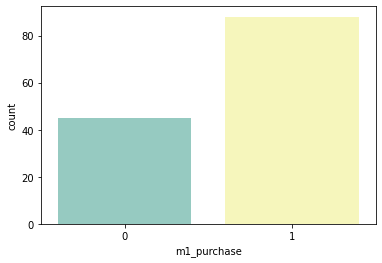

In [50]:
#exploring the data
#investigating the distribution of 'm1_purchase', our (y) variable 
sns.countplot(x='m1_purchase', data = df, palette='Set3')

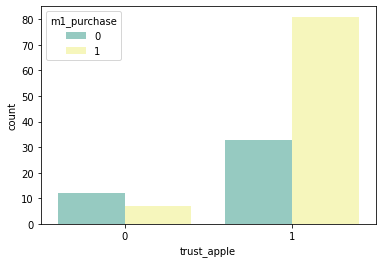

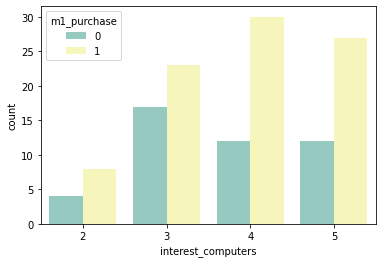

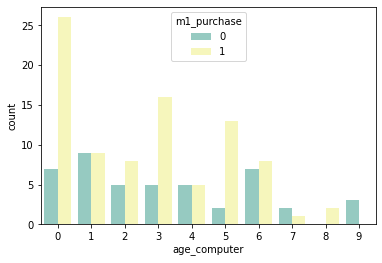

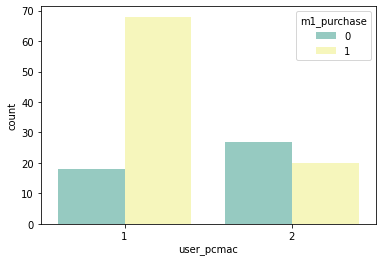

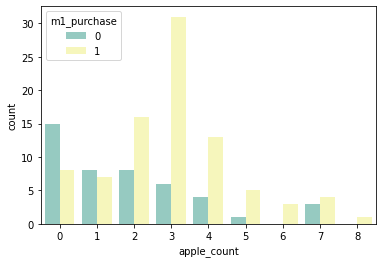

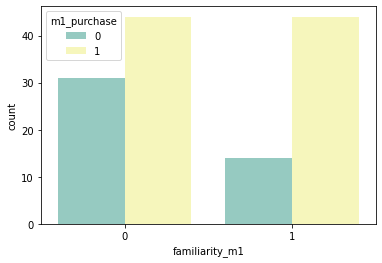

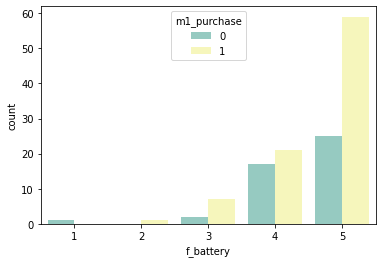

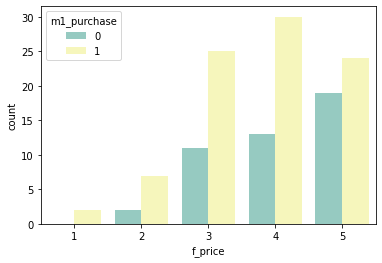

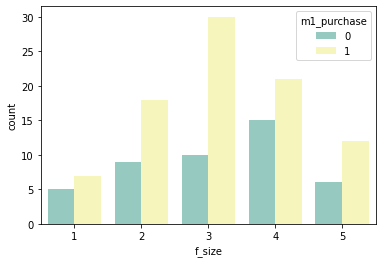

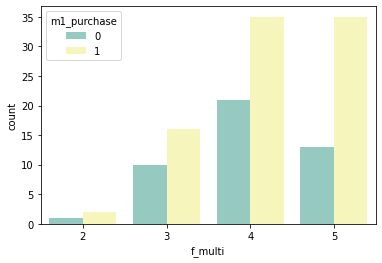

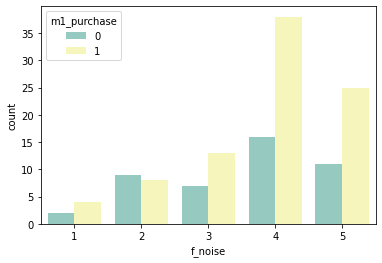

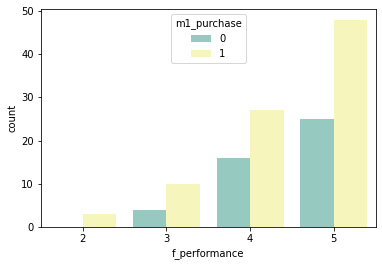

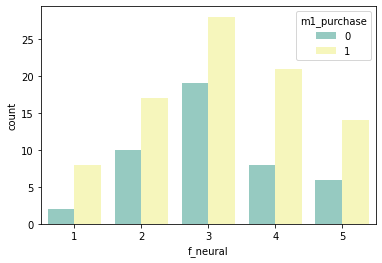

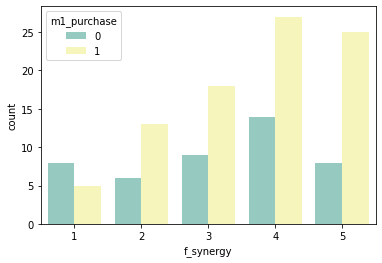

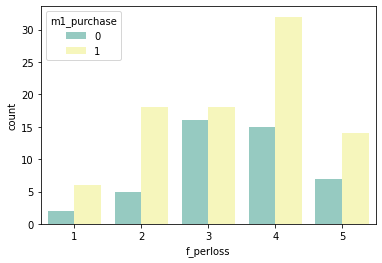

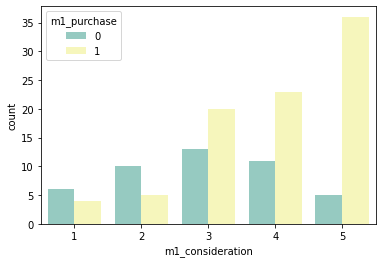

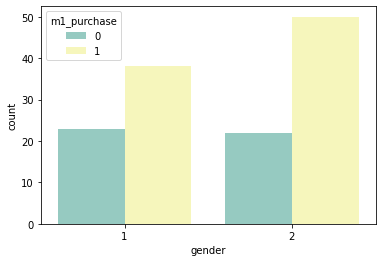

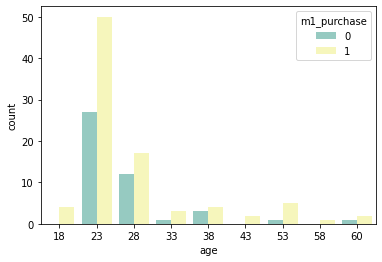

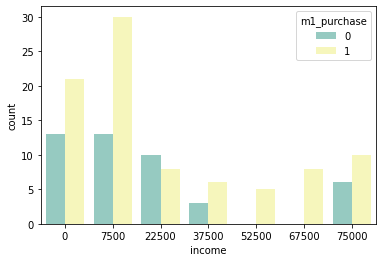

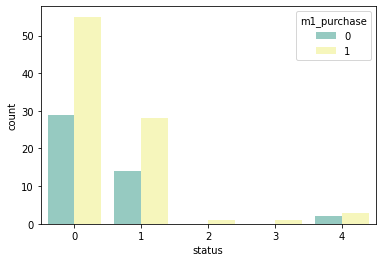

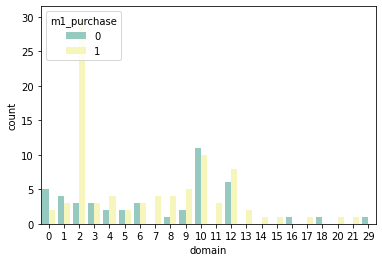

In [51]:
#exploring all the features in relation to 'm1_purchase'
#from this visualisation we can see which columns might be too similar to be useful for our model
features = ["trust_apple", "interest_computers", "age_computer",	
            "user_pcmac",	"apple_count",	"familiarity_m1",	"f_battery",	
            "f_price",	"f_size",	"f_multi",	"f_noise",	"f_performance",	
            "f_neural",	"f_synergy",	"f_perloss",	"m1_consideration",	
            "gender",	"age",	"income",	"status",	"domain"]

for f in features:
    sns.countplot(x = f, data = df, palette = 'Set3', hue = 'm1_purchase')
    plt.show()

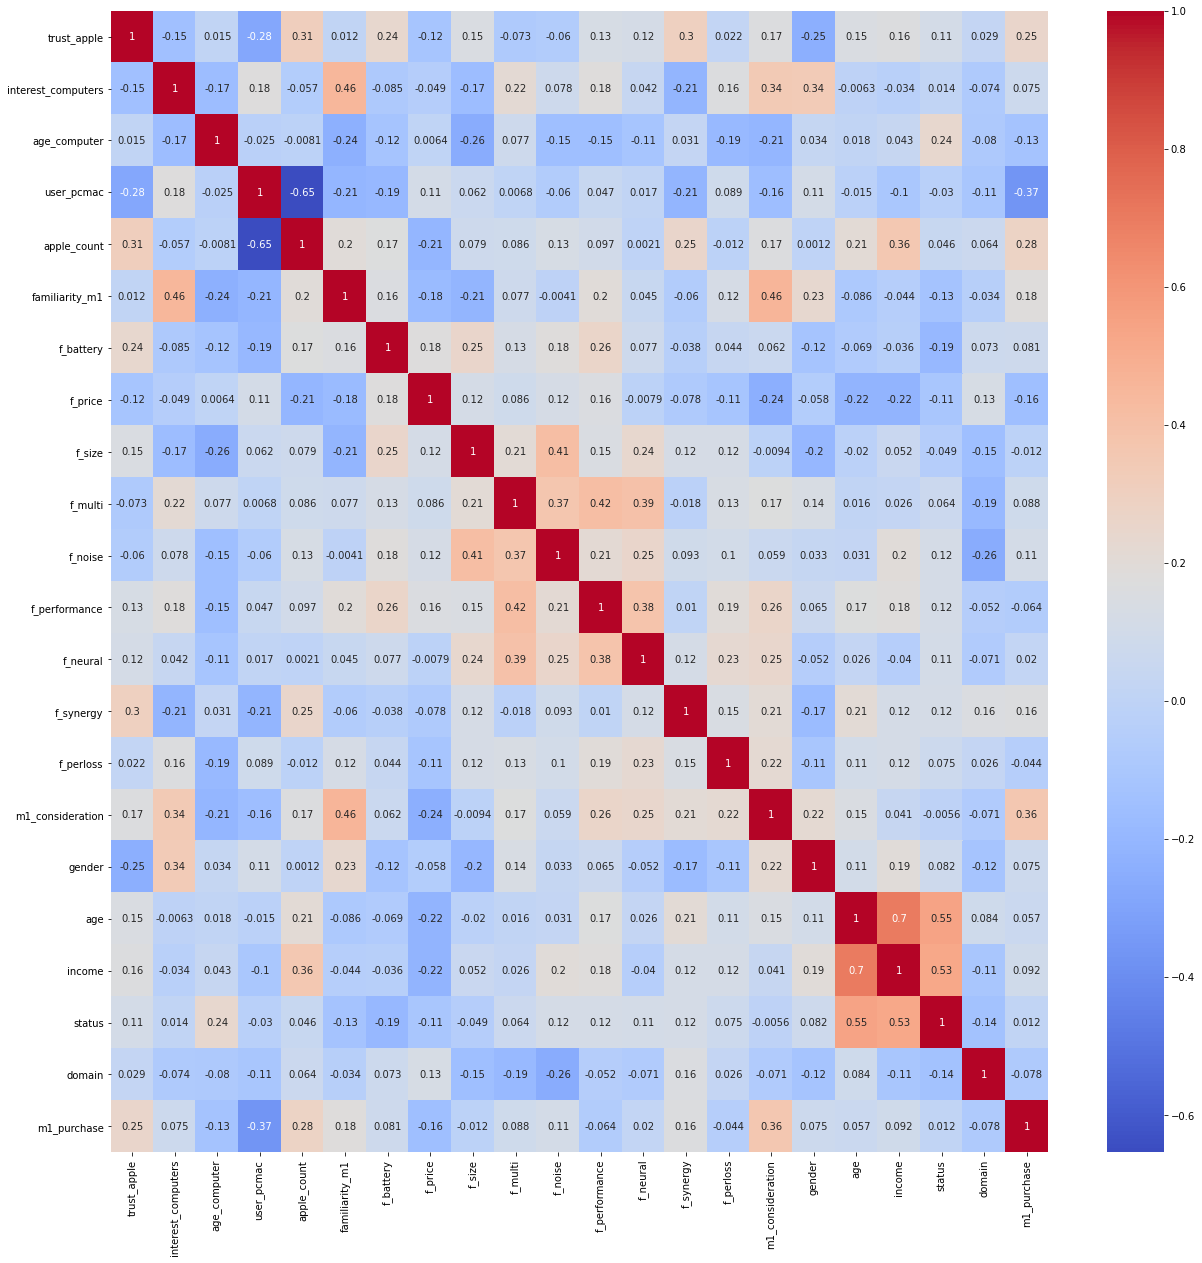

In [52]:
#using seaborn to display a complete correlation materix of the features
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(21,21))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="coolwarm")
#RdYlGn to change theme of correlation materix 

**Applying Feature Selection (dropping columns)**

In the following section **feature selection** methodology is applied to be able to find the columns (X) that have the strongest relation to (y). The goal of this is to figure out which columns to drop in the dataset before fitting the data to the logsitic regression algorithm. In this example, an algorithm from 'DecisionTreeClassifier' is used to give each feature a score in relation to (y).
The score is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature. Below are some general benefits of applying feature selection. 

Feature Selection: 
*   Reduces Overfitting: less redundant data means less opportunity to make decisions based on noise.
*   Improves Accuracy: less misleading data means modeling accuracy improves.
*   Reduces Training Time: fewer data points reduce algorithm complexity and algorithms train faster.

In [53]:

#split X (dependant variable) and Y (independant variables)
X = df.drop('m1_purchase', axis = 1).values
Y = df['m1_purchase']
print(X.shape)
print(Y.shape)

(133, 21)
(133,)


In [54]:
#running feature importance with DecisionTreeClassifier
#entropy is used to measure disorder in the columns
#max_depth defines the maximum depth of the tree/max features
dt = DecisionTreeClassifier(random_state = 15, criterion = 'entropy', max_depth = 10)
dt.fit(X,Y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=15, splitter='best')

In [55]:
#creating empty lists to append the values 
col = []
fi = []

#the parameter axis=1 refer to columns, while 0 refers to rows
for i, column in enumerate(df.drop('m1_purchase', axis = 1)):
  col.append(column)
  fi.append(dt.feature_importances_[i])

#displaying fi_df as a new dataframe displaying the feature importances 
fi_df = zip(col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['feature', 'feature_importance'])

#sorting the feature importance in ascending order
fi_df = fi_df.sort_values('feature_importance', ascending = False).reset_index()

#the last 5 columns have no relation to y at all
fi_df

,index,feature,feature_importance
0,14,f_perloss,0.121983
1,15,m1_consideration,0.118166
2,3,user_pcmac,0.108523
3,20,domain,0.089777
4,13,f_synergy,0.088404
5,2,age_computer,0.082403
6,18,income,0.078410
7,10,f_noise,0.068669
8,1,interest_computers,0.044750
9,11,f_performance,0.044592


In [56]:
#keep our 8 most important features (x)
columns_to_keep = fi_df['feature'][0:8]

#original dataframe 
print(df.shape)

#new dataframe with only the features we want (x)
print(df[columns_to_keep].shape)

(133, 22)
(133, 8)


In [57]:
#displaying 8 'most important' features that we decided to use
columns_to_keep

0           f_perloss
1    m1_consideration
2          user_pcmac
3              domain
4           f_synergy
5        age_computer
6              income
7             f_noise
Name: feature, dtype: object

In [58]:
#displaying the 8 most important features with data
df[columns_to_keep]

,f_perloss,m1_consideration,user_pcmac,domain,f_synergy,age_computer,income,f_noise
0,1,1,2,0,1,8,7500,4
1,4,2,2,1,2,4,22500,4
2,2,4,2,2,2,6,7500,1
3,3,2,1,3,4,6,7500,4
4,4,4,1,4,4,4,75000,4
...,...,...,...,...,...,...,...,...
128,3,5,2,9,3,0,22500,4
129,1,5,1,7,3,8,52500,4
130,5,5,1,10,4,0,22500,5
131,3,5,1,2,3,5,7500,4


In [59]:
#just to show another method of feature selection based on chi square
#this might be a better selection, but we chose to go with the other one

#feature selection based on chi square 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = df.iloc[:,0:21]  #independent columns
y = df.iloc[:,-1]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

            Features         Score
18            income  34033.123101
4        apple_count     14.365739
15  m1_consideration      7.509093
2       age_computer      4.648991
20            domain      3.193524
3         user_pcmac      3.056364
5     familiarity_m1      2.436015
13         f_synergy      1.631870
17               age      1.331542
0        trust_apple      1.216288


**Algorithm: Logistic Regression (Classification)**

As our input is one y ('m1_purchase'), and multiple x, the logistic regression algorithm can help us predict which customers (which features) are most likely to buy the new m1 mac. The output will be a probability for each feature to be 0 or 1, where 0 = False and 1 = True.


Logistic regression is a commonly used algorithm for classification problems that works by fitting an 'S' shaped function on the data.  Specifically, through a Sigmoid function, the data is normalized and given a percentage (%) between 0 and 1 of the feature being classified in one class. 






In [60]:
#split the data into X & y
#y = np.array(df["Height"]).reshape(-1,1)

X = df[columns_to_keep].values
X.astype(int)
#X = X.reshape(-1,1)

y = np.array(df['m1_purchase']).reshape(-1,1)
y = y.astype(int)

print(X.shape)
print(y.shape)

(133, 8)
(133, 1)


In [61]:
#creating a training and test set 
#the train and test size is set to the same size as it gave the best accuracy score
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.20, test_size = 0.20,random_state=25)

#scaling and normalizing the data (this also imporved the score)
sc = StandardScaler() 
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [62]:
#checking the shape of the train and test set
print(y_train.shape)
print(x_train.shape)
print(y_test.shape)
print(x_test.shape)

(26, 1)
(26, 8)
(27, 1)
(27, 8)


In [63]:
#training my model 
log_reg = LogisticRegression(random_state=20, multi_class='multinomial')
log_reg.fit(x_train, np.ravel(y_train,order='C'))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
#checking the accuray of our model
#'score' returns the mean accuracy on the given test data and label

#the training accuracy
score_train = log_reg.score(x_train, y_train)

#the testing accuracy
score_test = log_reg.score(x_test, y_test)

#after tuning the random state of log_reg and traintestsplit this is the best accuracy that we got
print(f'The Training Accuracy is: {round(score_train*100, 2)} %')
print(f'The Testing Accuracy is: {round(score_test*100, 2)} %')

The Training Accuracy is: 92.31 %
The Testing Accuracy is: 81.48 %


In [65]:
#with k - fold validation we receive a testing accuracy of 87% which is higher than the one achived on the normal test set
kfold = model_selection.KFold(n_splits=10)
model_kfold = LogisticRegression()
results_kfold = model_selection.cross_val_score(model_kfold, x_test, np.ravel(y_test,order='C'), cv=kfold)
print(f'The K-fold Testing Accuracy Is: {round(results_kfold.mean()*100.0, 2)} %')

The K-fold Testing Accuracy Is: 86.67 %


In [66]:
#print the tunable parameters
params = log_reg.get_params()
print(params)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'l2', 'random_state': 20, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [67]:
#making predictions
#specific predictions can also be made by indexing
y_pred = log_reg.predict(x_test)

In [68]:
#predicted values based on the training set 
print(f'\nPredicted m1 purchases: {y_pred}')


Predicted m1 purchases: [1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1]


In [69]:
#actual values of y 
print(f'Real m1 purchases: {y_test.ravel()}')

Real m1 purchases: [1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1]


In [70]:
#printing the model parameters 
print('Intercept: \n', log_reg.intercept_)
print('Coefficients: \n', log_reg.coef_)

Intercept: 
 [0.80665753]
Coefficients: 
 [[-0.54492456  0.32249184 -0.61505633 -0.53191456  0.62302438 -0.37628924
  -0.12636243  0.33257459]]


In [71]:
#shape of coefficient and intercept 
print(log_reg.coef_.shape) 
print(log_reg.intercept_.shape) 

(1, 8)
(1,)


In [72]:
#the predicted probabilities of data instances being classified as 1 (customers will purchase m1) when the model is applied on the test set
log = log_reg.predict_proba(x_test)[:,1].reshape(-1,1)
df_prob = pd.DataFrame(log, columns = ['probability_of_purchase'])
df_prob.probability_of_purchase = (round(df_prob.probability_of_purchase * 100, 2)).astype(str) + '%'
df_prob.sort_values('probability_of_purchase', ascending = False).reset_index()

,index,probability_of_purchase
0,26,99.7%
1,12,99.68%
2,7,99.66%
3,17,99.64%
4,18,98.92%
5,15,98.51%
6,10,98.31%
7,5,97.36%
8,13,97.25%
9,21,95.62%


In [73]:
#displaying the 5 most predicted most probable puchasers (data instances) in a dataframe with their features 
#the classification for purchaser3 and purchaser4 is likely inaccurate
user1 = df.iloc[26,:]
user2 = df.iloc[12,:] 
user3 = df.iloc[7,:] 
user4 = df.iloc[17,:] 
user5 = df.iloc[18,:]

users = zip(user1, user2, user3, user4, user5)
users = pd.DataFrame(users, columns = ['purchaser1', 'purchaser2', 'purchaser3', 'purchaser4', 'purchaser5'])#.reset_index()
users = users.rename(index={0: 'trust_apple', 1: 'interest_computers', 2: 'age_computer', 3: 'user_pcmac', 4: 'apple_count', 5: 'familiarity_m1', 6: 'f_battery', 7: 'f_price', 8: 'f_size', 9: 'f_multi', 10: 'f_noise', 11: 'f_performance', 12: 'f_neural', 13: 'f_synergy', 14: 'f_perloss', 15: 'm1_consideration', 16: 'gender', 17: 'age', 18: 'income', 19: 'status', 20: 'domain', 21: 'm1_purchase'})
users

,purchaser1,purchaser2,purchaser3,purchaser4,purchaser5
trust_apple,1,1,0,0,1
interest_computers,4,4,3,3,4
age_computer,4,3,0,0,0
user_pcmac,1,2,2,2,1
apple_count,7,3,0,0,4
familiarity_m1,1,0,0,0,0
f_battery,5,5,5,5,5
f_price,3,3,5,5,2
f_size,3,4,4,4,5
f_multi,4,3,4,3,5


In [74]:
#confusion materix 
confmtrx = np.array(confusion_matrix(y_test, y_pred))


cm = pd.DataFrame(confmtrx, index=['Actual Not Buyers', 'Actual Buyers'],
columns=['Predicted Not Buyers', 'Predicted Buyers'])
cm

,Predicted Not Buyers,Predicted Buyers
Actual Not Buyers,3,3
Actual Buyers,2,19


In [75]:
#calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)

FP = confmtrx.sum(axis=0) - np.diag(confmtrx)
FN = confmtrx.sum(axis=1) - np.diag(confmtrx)
TP = np.diag(confmtrx)
TN = confmtrx.sum() - (FP + FN + TP)

#true positive rate (sensitivity)
TPR = TP / (TP + FN)

#true negative (precision)
TNR = TP / (TP + FP)

#false positive rate or False alarm rate
FPR = FP / (FP + TN)

#false negative rate or Miss Rate
FNR = FN / (FN + TP)

#the averages
print(f'The average True Positive Rate is: {round((TPR.sum()/2)*100, 2)} %')
print(f'The average True Negative Rate is: {round((TNR.sum()/2)*100, 2)} %')
print(f'The average False Positive Rate is: {round((FPR.sum()/2)*100, 2)} %')
print(f'The average False Negative Rate is: {round((FNR.sum()/2)*100, 2)} %')


The average True Positive Rate is: 70.24 %
The average True Negative Rate is: 73.18 %
The average False Positive Rate is: 29.76 %
The average False Negative Rate is: 29.76 %


In [76]:
#calculating the logarithmic loss of our model
#as log loss measurer uncertainty -> a low value equals a model of low uncertainty which is good
print(cl('The Log Loss of the Model is {}'.format(log_loss(y_test, y_pred).round(2))))

The Log Loss of the Model is 6.4


In the small training and testing sets used, the algorithm classified the data instance **wrong 5/27** and **correct 22/27** times as shown in the confusion matrix. To further increase the accuracy of this model, hyper parameter tuning would need to be applied. It is also worth noting that even with optimal parameters the model might not perform better due to the data being insufficient. 